<a href="https://colab.research.google.com/github/justinePrasad/HofstraASPiRe2023/blob/main/KFACNodeClassificationGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

In [2]:
import torch

print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [3]:
#installs based on version
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 23.1 MB/s eta 0:00:00


In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=c3eb77074dab959fc5de116611e86b035c719d5de137d5a620a1b2d42d576cbd
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


Importing Dataset


In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="/tmp/Cora", name="Cora", transform=NormalizeFeatures())

Processing...
Done!


Looking at Data Distruution

In [6]:
print()
print(f'Dataset: {dataset}')
print('====================')
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

data=dataset[0]

print()
print(data)
print('================================================================')

#gather statistics about the graph
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f"Average Node Degree:  {data.num_edges / data.num_nodes :.2f}")
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


print(dataset.num_classes) #output dimension
print(dataset.num_features) #input dimension


print(f"Node Features: {data.x}")
print(f"Node Labels: {data.y}")
print(f"Adj. List: {data.edge_index}")
print(data) #attributes of data


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average Node Degree:  3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True
7
1433
Node Features: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Node Labels: tensor([3, 4, 4,  ..., 3, 3, 3])
Adj. List: tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [7]:
#Finding the distrubution
num_edges = data.edge_index.shape[1] #why is it shape 1
num_nodes = data.x.shape[0]

avg_cit = num_edges/num_nodes
print(f"Avg. Number of citations per paper: {avg_cit}")

Avg. Number of citations per paper: 3.8980797636632203


In [8]:
import numpy as np

#distrubution of each word in papers
word_counts = np.sum(data.x.numpy(), axis=0)
word_dis = word_counts/ num_nodes

print(f"Word Distribution: {word_dis}") #represents freq of each word across all papers

Word Distribution: [0.00027324 0.00062631 0.00129225 ... 0.00013502 0.0012015  0.00022694]


Visualizing Data

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

edge_index = data.edge_index.numpy()
G = nx.Graph()
for i in range(edge_index.shape[1]):
  G.add_edge(edge_index[0,i], edge_index[1,i]) #source and target node respectively

#calc the degrees
degrees = [G.degree(n) for n in G.nodes()]

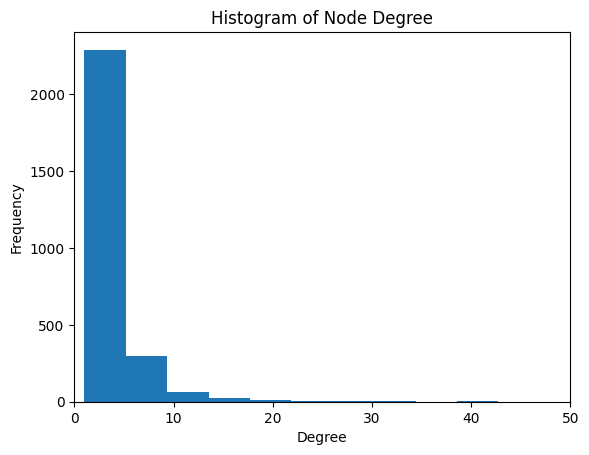

In [10]:
#create the histogram
plt.hist(degrees, bins=40)
plt.title('Histogram of Node Degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.xlim([0,50])
plt.show()

Data preprocessing


In [11]:
import scipy.sparse

#feature matrix
data = dataset[0]
#2708 by 1433
feature_matrix = data.x.numpy()

#adj matrix -> can be inferred from the 'edge index' attribute
num_nodes = data.num_nodes
edge_index = data.edge_index.numpy()

#args (data, (i,j)), shape
adj_matrix = scipy.sparse.coo_matrix((np.ones(edge_index.shape[1]), edge_index), shape=(num_nodes, num_nodes))

In [12]:
# %%script false
# #test to make sure edges are correctly represented

# #checks each edge in edge_index and sees if the corresponding entry is
# scr_matrix = adj_matrix.tocsr()

# for i in range(20):
#   source = edge_index[0,i]
#   target = edge_index[1, i]

#   if scr_matrix[source, target] != 1:
#     print(f"Edge ({source}, {target}) is not correctly represented")

Training GCN Model

In [13]:
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

class CRD(torch.nn.Module):
  def __init__(self, d_in, d_out, p):
    super(CRD, self).__init__()
    # Snice the structure of the graph doesn't change, cache allows the the adj. matrix of the graph to be reused
    self.conv = GCNConv(d_in, d_out, cached=True)
    self.p = p

  def reset_parameters(self):
    self.conv.reset_parameters()

  def forward(self, x, edge_index, mask=None):
    x = F.relu(self.conv(x, edge_index))
    x = F.dropout(x, p=self.p, training=self.training)
    return x

class CLS (torch.nn.Module):
  def __init__(self, d_in, d_out):
    super(CLS, self).__init__()
    self.conv = GCNConv(d_in, d_out, cached=True)

  def reset_parameters():
    self.conv.reset_parameters()

  def forward(self, x, edge_index, mask=None):
    x = self.conv(x, edge_index)
    x = F.log_softmax(x, dim=1) # To returnt the probablity of the class
    return x

class Net(torch.nn.Module):
  def __init__(self, hidden_channels, dropout, num_features=dataset.num_features, num_classes=dataset.num_classes):
    super(Net, self).__init__()
    self.crd = CRD(dataset.num_features, hidden_channels, dropout)  #GCN layer?
    self.cls = CLS(hidden_channels, dataset.num_classes) #classification layer

  def reset_parameters(self):
    self.crd.reset_parameters()
    self.cls.reset_parameters()

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    x = self.crd(x, edge_index,data.train_mask)
    x = self.cls(x, edge_index,data.train_mask)

    return x



In [21]:
model = Net(hidden_channels=64, dropout=0.5)
print(model)

Net(
  (crd): CRD(
    (conv): GCNConv(1433, 64)
  )
  (cls): CLS(
    (conv): GCNConv(64, 7)
  )
)


Using TSNE to visualize node on 2D plane

In [15]:
#Todo comment how code works

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

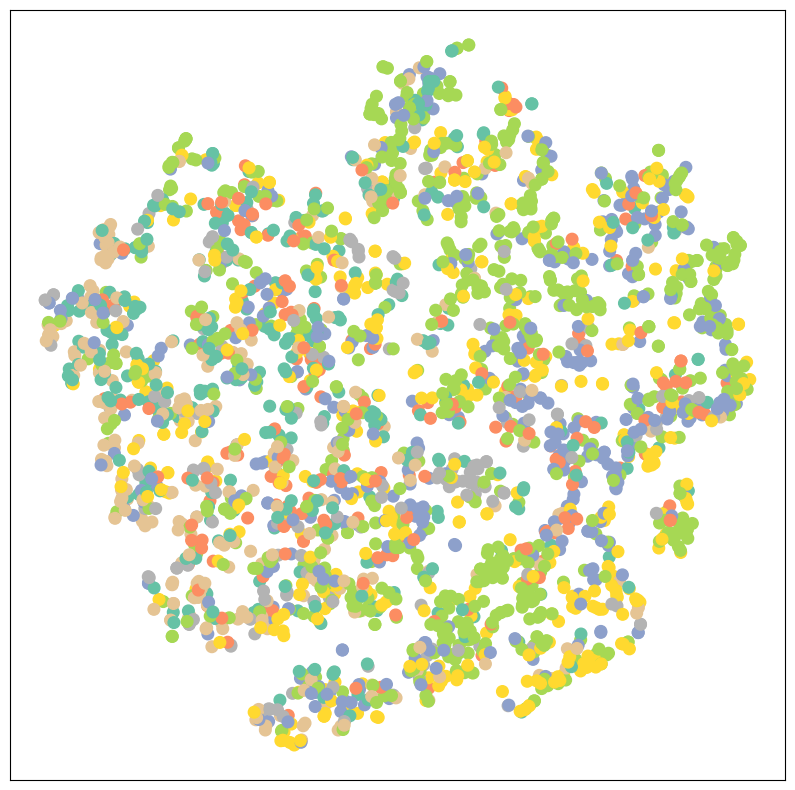

In [16]:
model = Net(hidden_channels=8, dropout=0.1)
model.eval()

out = model(data)
visualize(out, color = data.y)

Implementation of KFAC from https://github.com/Thrandis/EKFAC-pytorch/blob/master/kfac.py

In [17]:
import torch
import torch.nn.functional as F

from torch.optim.optimizer import Optimizer


class KFAC(Optimizer):

    def __init__(self, net, eps, sua=False, pi=False, update_freq=1,
                 alpha=1.0, constraint_norm=False):
        """ K-FAC Preconditionner for Linear and Conv2d layers.

        Computes the K-FAC of the second moment of the gradients.
        It works for Linear and Conv2d layers and silently skip other layers.

        Args:
            net (torch.nn.Module): Network to precondition.
            eps (float): Tikhonov regularization parameter for the inverses.
            sua (bool): Applies SUA approximation.
            pi (bool): Computes pi correction for Tikhonov regularization.
            update_freq (int): Perform inverses every update_freq updates.
            alpha (float): Running average parameter (if == 1, no r. ave.).
            constraint_norm (bool): Scale the gradients by the squared
                fisher norm.
        """
        self.eps = eps
        self.sua = sua
        self.pi = pi
        self.update_freq = update_freq
        self.alpha = alpha
        self.constraint_norm = constraint_norm
        self.params = []
        self._fwd_handles = []
        self._bwd_handles = []
        self._iteration_counter = 0
        for mod in net.modules():
            mod_class = mod.__class__.__name__
            if mod_class in ['Linear', 'Conv2d']:
                handle = mod.register_forward_pre_hook(self._save_input)
                self._fwd_handles.append(handle)
                handle = mod.register_full_backward_hook(self._save_grad_output)
                self._bwd_handles.append(handle)
                params = [mod.weight]
                if mod.bias is not None:
                    params.append(mod.bias)
                d = {'params': params, 'mod': mod, 'layer_type': mod_class}
                self.params.append(d)
        super(KFAC, self).__init__(self.params, {})

    def step(self, update_stats=True, update_params=True):
        """Performs one step of preconditioning."""
        fisher_norm = 0.
        for group in self.param_groups:
            # Getting parameters
            if len(group['params']) == 2:
                weight, bias = group['params']
            else:
                weight = group['params'][0]
                bias = None
            state = self.state[weight]
            # Update convariances and inverses
            if update_stats:
                if self._iteration_counter % self.update_freq == 0:
                    self._compute_covs(group, state)
                    ixxt, iggt = self._inv_covs(state['xxt'], state['ggt'],
                                                state['num_locations'])
                    state['ixxt'] = ixxt
                    state['iggt'] = iggt
                else:
                    if self.alpha != 1:
                        self._compute_covs(group, state)
            if update_params:
                # Preconditionning
                gw, gb = self._precond(weight, bias, group, state)
                # Updating gradients
                if self.constraint_norm:
                    fisher_norm += (weight.grad * gw).sum()
                weight.grad.data = gw
                if bias is not None:
                    if self.constraint_norm:
                        fisher_norm += (bias.grad * gb).sum()
                    bias.grad.data = gb
            # Cleaning
            if 'x' in self.state[group['mod']]:
                del self.state[group['mod']]['x']
            if 'gy' in self.state[group['mod']]:
                del self.state[group['mod']]['gy']
        # Eventually scale the norm of the gradients
        if update_params and self.constraint_norm:
            scale = (1. / fisher_norm) ** 0.5
            for group in self.param_groups:
                for param in group['params']:
                    param.grad.data *= scale
        if update_stats:
            self._iteration_counter += 1

    def _save_input(self, mod, i):
        """Saves input of layer to compute covariance."""
        if mod.training:
            self.state[mod]['x'] = i[0]

    def _save_grad_output(self, mod, grad_input, grad_output):
        """Saves grad on output of layer to compute covariance."""
        if mod.training:
            self.state[mod]['gy'] = grad_output[0] * grad_output[0].size(0)

    def _precond(self, weight, bias, group, state):
        """Applies preconditioning."""
        if group['layer_type'] == 'Conv2d' and self.sua:
            return self._precond_sua(weight, bias, group, state)
        ixxt = state['ixxt']
        iggt = state['iggt']
        g = weight.grad.data
        s = g.shape
        if group['layer_type'] == 'Conv2d':
            g = g.contiguous().view(s[0], s[1]*s[2]*s[3])
        if bias is not None:
            gb = bias.grad.data
            g = torch.cat([g, gb.view(gb.shape[0], 1)], dim=1)
        g = torch.mm(torch.mm(iggt, g), ixxt)
        if group['layer_type'] == 'Conv2d':
            g /= state['num_locations']
        if bias is not None:
            gb = g[:, -1].contiguous().view(*bias.shape)
            g = g[:, :-1]
        else:
            gb = None
        g = g.contiguous().view(*s)
        return g, gb

    def _precond_sua(self, weight, bias, group, state):
        """Preconditioning for KFAC SUA."""
        ixxt = state['ixxt']
        iggt = state['iggt']
        g = weight.grad.data
        s = g.shape
        mod = group['mod']
        g = g.permute(1, 0, 2, 3).contiguous()
        if bias is not None:
            gb = bias.grad.view(1, -1, 1, 1).expand(1, -1, s[2], s[3])
            g = torch.cat([g, gb], dim=0)
        g = torch.mm(ixxt, g.contiguous().view(-1, s[0]*s[2]*s[3]))
        g = g.view(-1, s[0], s[2], s[3]).permute(1, 0, 2, 3).contiguous()
        g = torch.mm(iggt, g.view(s[0], -1)).view(s[0], -1, s[2], s[3])
        g /= state['num_locations']
        if bias is not None:
            gb = g[:, -1, s[2]//2, s[3]//2]
            g = g[:, :-1]
        else:
            gb = None
        return g, gb

    def _compute_covs(self, group, state):
        """Computes the covariances."""
        mod = group['mod']
        x = self.state[group['mod']]['x']
        gy = self.state[group['mod']]['gy']
        # Computation of xxt
        if group['layer_type'] == 'Conv2d':
            if not self.sua:
                x = F.unfold(x, mod.kernel_size, padding=mod.padding,
                             stride=mod.stride)
            else:
                x = x.view(x.shape[0], x.shape[1], -1)
            x = x.data.permute(1, 0, 2).contiguous().view(x.shape[1], -1)
        else:
            x = x.data.t()
        if mod.bias is not None:
            ones = torch.ones_like(x[:1])
            x = torch.cat([x, ones], dim=0)
        if self._iteration_counter == 0:
            state['xxt'] = torch.mm(x, x.t()) / float(x.shape[1])
        else:
            state['xxt'].addmm_(mat1=x, mat2=x.t(),
                                beta=(1. - self.alpha),
                                alpha=self.alpha / float(x.shape[1]))
        # Computation of ggt
        if group['layer_type'] == 'Conv2d':
            gy = gy.data.permute(1, 0, 2, 3)
            state['num_locations'] = gy.shape[2] * gy.shape[3]
            gy = gy.contiguous().view(gy.shape[0], -1)
        else:
            gy = gy.data.t()
            state['num_locations'] = 1
        if self._iteration_counter == 0:
            state['ggt'] = torch.mm(gy, gy.t()) / float(gy.shape[1])
        else:
            state['ggt'].addmm_(mat1=gy, mat2=gy.t(),
                                beta=(1. - self.alpha),
                                alpha=self.alpha / float(gy.shape[1]))

    def _inv_covs(self, xxt, ggt, num_locations):
        """Inverses the covariances."""
        # Computes pi
        pi = 1.0
        if self.pi:
            tx = torch.trace(xxt) * ggt.shape[0]
            tg = torch.trace(ggt) * xxt.shape[0]
            pi = (tx / tg)
        # Regularizes and inverse
        eps = self.eps / num_locations
        diag_xxt = xxt.new(xxt.shape[0]).fill_((eps * pi) ** 0.5)
        diag_ggt = ggt.new(ggt.shape[0]).fill_((eps / pi) ** 0.5)
        ixxt = (xxt + torch.diag(diag_xxt)).inverse()
        iggt = (ggt + torch.diag(diag_ggt)).inverse()
        return ixxt, iggt

    def __del__(self):
        for handle in self._fwd_handles + self._bwd_handles:
            handle.remove()

Training and Testing Model

- Will be adding splits

In [25]:
from torch.optim.optimizer import Optimizer

#inits an optimizer with a specific learning rate and weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
#Common loss function that is used
criterion = torch.nn.CrossEntropyLoss()


preconditioner = KFAC(model, 0.1, update_freq=10)

def train():
  model.train() #switches to training mode
  optimizer.zero_grad() #clear gradients from last step
  out = model(data) #does a single forward pass
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) #compute loss from training nodes
  loss.backward() #derive gradients
  preconditioner.step()
  optimizer.step() #update parameters based on gradients
  return loss

def test(mask):
  model.eval()
  out = model(data)
  pred = out.argmax(dim=1) #Use the class with the highest probability
  correct = pred[mask] == data.y[mask] #In order to check against ground-truth labels
  acc = int(correct.sum()) / int(mask.sum())
  return acc

for epoch in range(1, 101):
  loss = train()
  val_acc = test(data.val_mask)
  test_acc = test(data.test_mask)
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.3f}. Test: {test_acc:.3f}')


Epoch: 001, Loss: 0.0146, Val: 0.768. Test: 0.799
Epoch: 002, Loss: 0.0214, Val: 0.788. Test: 0.801
Epoch: 003, Loss: 0.0186, Val: 0.784. Test: 0.797
Epoch: 004, Loss: 0.0191, Val: 0.784. Test: 0.802
Epoch: 005, Loss: 0.0203, Val: 0.772. Test: 0.807
Epoch: 006, Loss: 0.0209, Val: 0.786. Test: 0.808
Epoch: 007, Loss: 0.0186, Val: 0.786. Test: 0.814
Epoch: 008, Loss: 0.0161, Val: 0.788. Test: 0.812
Epoch: 009, Loss: 0.0201, Val: 0.792. Test: 0.805
Epoch: 010, Loss: 0.0174, Val: 0.782. Test: 0.796
Epoch: 011, Loss: 0.0185, Val: 0.778. Test: 0.796
Epoch: 012, Loss: 0.0177, Val: 0.778. Test: 0.795
Epoch: 013, Loss: 0.0207, Val: 0.786. Test: 0.796
Epoch: 014, Loss: 0.0236, Val: 0.784. Test: 0.802
Epoch: 015, Loss: 0.0202, Val: 0.780. Test: 0.804
Epoch: 016, Loss: 0.0240, Val: 0.780. Test: 0.807
Epoch: 017, Loss: 0.0162, Val: 0.772. Test: 0.807
Epoch: 018, Loss: 0.0164, Val: 0.784. Test: 0.808
Epoch: 019, Loss: 0.0146, Val: 0.786. Test: 0.805
Epoch: 020, Loss: 0.0160, Val: 0.786. Test: 0.810


In [19]:
print(model)

Net(
  (crd): CRD(
    (conv): GCNConv(1433, 8)
  )
  (cls): CLS(
    (conv): GCNConv(8, 7)
  )
)


Results of Different Model Architecture

3 GCN Layers: Epoch: 100, Loss: 0.7956, Val: 0.786. Test: 0.794

2 GCN Layers: Epoch: 100, Loss: 0.5799, Val: 0.778. Test: 0.815

2 Layer GAT: Epoch: 100, Loss: 0.2573, Val: 0.790. Test: 0.785  Note: Might be overfiting

2 GCN layer mode performs better

Model SDG+KFAC w 8 channels: Epoch: 100, Loss: 0.0143, Val: 0.786. Test: 0.802

Model SDG + KFAC w 64 channels and lr: Epoch: 100, Loss: 1.9396, Val: 0.324. Test: 0.360

Model Adam + KFAC w 64 channels, 0.5 dropout: Epoch: 100, Loss: 0.0174, Val: 0.784. Test: 0.798



### Why is the low training loss and relatively lower validation and test accuracy?

  1. Overfitting - Use regularization techniques, early stopping, more training data
  2. Mismatch between Loss Function and Metric
    - Ensure that the loss function aligns with problem objectives
  3. Class Imbalance
  4. Try using cross-validation to tune hypermparameters


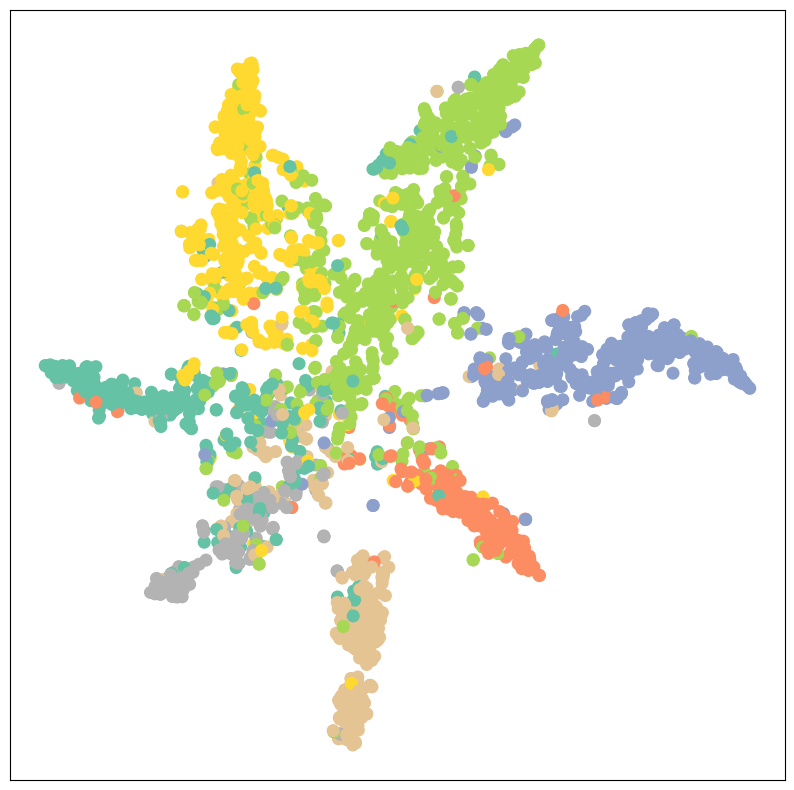

In [26]:
model.eval()

out = model(data)
visualize(out, color=data.y)